# Model v6 - Title Features Experiment

**Goal:** Test if title features improve prediction accuracy over v5.

## Comparison

| Model | Features | Expected R² |
|-------|----------|-------------|
| v5 | IMDb core + Genres + Plot PCA + Budget | ~0.42 |
| v6 | v5 + Title features (1 simple + 10 PCA) | ? |

**New Title Features:**
- `title_has_colon` - subtitle indicator
- `title_pca_0` to `title_pca_9` - semantic embeddings

---
## 1. Setup

In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Paths
DATA_DIR = Path("../../data/processed")
MODELS_DIR = Path("../../models")

print("Setup complete!")

Setup complete!


---
## 2. Load Data

In [12]:
# Load the rich dataset (movies with TMDB data)
df = pd.read_csv(DATA_DIR / "movies_rich_wide.csv")

print(f"Loaded {len(df):,} movies")
print(f"Columns: {len(df.columns)}")
print(f"\nNew title columns:")
title_cols = [c for c in df.columns if 'title' in c.lower()]
print(f"  {title_cols}")

Loaded 38,240 movies
Columns: 66

New title columns:
  ['title_has_colon', 'title_pca_0', 'title_pca_1', 'title_pca_2', 'title_pca_3', 'title_pca_4', 'title_pca_5', 'title_pca_6', 'title_pca_7', 'title_pca_8', 'title_pca_9']


---
## 3. Define Feature Sets

In [13]:
TARGET = "averageRating"

# Genre columns
GENRE_COLS = [col for col in df.columns if col.startswith("Genre_")]

# Plot PCA columns
PLOT_PCA_COLS = [f"pca_{i}" for i in range(20)]

# Title PCA columns
TITLE_PCA_COLS = [f"title_pca_{i}" for i in range(10)]

# V5 features (baseline - no votes, no revenue)
FEATURES_V5 = [
    # IMDb Core (5)
    "movie_age", "decade", "runtimeMinutes_capped", "genre_count", "isAdult"
] + GENRE_COLS + PLOT_PCA_COLS + [
    # Budget (2)
    "log_budget", "has_budget"
]

# V6 features (V5 + title features)
TITLE_FEATURES = ["title_has_colon"] + TITLE_PCA_COLS
FEATURES_V6 = FEATURES_V5 + TITLE_FEATURES

print(f"V5 features: {len(FEATURES_V5)}")
print(f"V6 features: {len(FEATURES_V6)} (+{len(TITLE_FEATURES)} title features)")
print(f"\nTitle features: {TITLE_FEATURES}")

V5 features: 49
V6 features: 60 (+11 title features)

Title features: ['title_has_colon', 'title_pca_0', 'title_pca_1', 'title_pca_2', 'title_pca_3', 'title_pca_4', 'title_pca_5', 'title_pca_6', 'title_pca_7', 'title_pca_8', 'title_pca_9']


---
## 4. Train and Compare Models

In [14]:
def train_and_evaluate(df, features, model_name):
    """Train GB model and return metrics."""
    X = df[features].fillna(0)
    y = df[TARGET]
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train
    model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"{model_name}: R²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")
    
    return {
        "model": model_name,
        "n_features": len(features),
        "R2": round(r2, 4),
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4),
        "trained_model": model
    }

In [15]:
print("=" * 60)
print("MODEL COMPARISON: V5 vs V6")
print("=" * 60)

# Train both models
result_v5 = train_and_evaluate(df, FEATURES_V5, "V5 (baseline)")
result_v6 = train_and_evaluate(df, FEATURES_V6, "V6 (+ title)")

# Calculate improvement
r2_diff = result_v6["R2"] - result_v5["R2"]
pct_improvement = (r2_diff / result_v5["R2"]) * 100

print("\n" + "=" * 60)
print("RESULTS")
print("=" * 60)
print(f"V5 R²: {result_v5['R2']:.4f} ({result_v5['n_features']} features)")
print(f"V6 R²: {result_v6['R2']:.4f} ({result_v6['n_features']} features)")
print(f"\nDifference: {r2_diff:+.4f} ({pct_improvement:+.2f}% relative improvement)")

if r2_diff > 0.005:
    print("\n✅ Title features IMPROVE the model")
elif r2_diff < -0.005:
    print("\n❌ Title features HURT the model")
else:
    print("\n⚠️ Title features have NEGLIGIBLE effect")

MODEL COMPARISON: V5 vs V6
V5 (baseline): R²=0.4099, MAE=0.6202, RMSE=0.8252
V6 (+ title): R²=0.4072, MAE=0.6215, RMSE=0.8271

RESULTS
V5 R²: 0.4099 (49 features)
V6 R²: 0.4072 (60 features)

Difference: -0.0027 (-0.66% relative improvement)

⚠️ Title features have NEGLIGIBLE effect


---
## 5. Feature Importance Analysis

In [16]:
# Get feature importances from V6 model
model_v6 = result_v6["trained_model"]

importance_df = pd.DataFrame({
    "feature": FEATURES_V6,
    "importance": model_v6.feature_importances_
}).sort_values("importance", ascending=False)

print("=" * 60)
print("TOP 20 FEATURES BY IMPORTANCE")
print("=" * 60)
print(importance_df.head(20).to_string(index=False))

TOP 20 FEATURES BY IMPORTANCE
              feature  importance
runtimeMinutes_capped    0.181623
         Genre_Horror    0.168989
            movie_age    0.129161
    Genre_Documentary    0.106973
          Genre_Drama    0.072007
      Genre_Animation    0.030820
         Genre_Action    0.027345
           log_budget    0.027177
                pca_5    0.024289
               pca_15    0.020987
                pca_4    0.018176
         Genre_Sci-Fi    0.014557
               pca_10    0.012444
               pca_11    0.011071
                pca_2    0.010641
                pca_1    0.007813
               pca_18    0.007081
                pca_9    0.006768
                pca_6    0.006582
          title_pca_4    0.006357


In [17]:
# How do title features rank?
print("=" * 60)
print("TITLE FEATURES RANKING")
print("=" * 60)

title_importance = importance_df[importance_df["feature"].isin(TITLE_FEATURES)]
print(title_importance.to_string(index=False))

# Total importance of title features
total_title_importance = title_importance["importance"].sum()
print(f"\nTotal title feature importance: {total_title_importance:.4f} ({total_title_importance*100:.2f}%)")

TITLE FEATURES RANKING
        feature  importance
    title_pca_4    0.006357
    title_pca_3    0.004546
    title_pca_5    0.004470
    title_pca_9    0.004360
    title_pca_2    0.004344
    title_pca_1    0.004299
    title_pca_8    0.004263
    title_pca_7    0.004164
    title_pca_0    0.003753
    title_pca_6    0.002437
title_has_colon    0.000313

Total title feature importance: 0.0433 (4.33%)


---
## 5.1 Correlation Analysis

Are title features redundant with existing features? Let's check correlations.

In [18]:
# Correlation: Title PCA vs Plot PCA
# Are title embeddings capturing the same info as plot embeddings?

print("=" * 60)
print("TITLE PCA vs PLOT PCA CORRELATION")
print("=" * 60)

# Calculate correlation matrix between title PCA and plot PCA
title_plot_corr = df[TITLE_PCA_COLS + PLOT_PCA_COLS].corr()

# Extract just the cross-correlation (title vs plot)
cross_corr = title_plot_corr.loc[TITLE_PCA_COLS, PLOT_PCA_COLS]

# Find highest correlations
print("\nHighest correlations between title_pca and pca features:")
corr_pairs = []
for title_col in TITLE_PCA_COLS:
    for plot_col in PLOT_PCA_COLS:
        corr_pairs.append({
            "title_feature": title_col,
            "plot_feature": plot_col,
            "correlation": abs(cross_corr.loc[title_col, plot_col])
        })

corr_df = pd.DataFrame(corr_pairs).sort_values("correlation", ascending=False)
print(corr_df.head(15).to_string(index=False))

# Summary stats
max_corr = corr_df["correlation"].max()
mean_corr = corr_df["correlation"].mean()
print(f"\nMax correlation: {max_corr:.4f}")
print(f"Mean correlation: {mean_corr:.4f}")

TITLE PCA vs PLOT PCA CORRELATION

Highest correlations between title_pca and pca features:
title_feature plot_feature  correlation
  title_pca_3        pca_0     0.305438
  title_pca_4        pca_0     0.287429
  title_pca_0        pca_4     0.269167
  title_pca_8        pca_2     0.227642
  title_pca_9        pca_3     0.200970
  title_pca_1        pca_9     0.193123
  title_pca_6        pca_0     0.181691
  title_pca_2        pca_2     0.175921
  title_pca_7        pca_7     0.162220
  title_pca_2        pca_4     0.159517
  title_pca_0       pca_11     0.152826
  title_pca_6        pca_1     0.152290
  title_pca_9        pca_1     0.151825
  title_pca_4        pca_3     0.148959
  title_pca_9        pca_4     0.136351

Max correlation: 0.3054
Mean correlation: 0.0574


In [19]:
# Correlation: Title features vs Genres
# Are title embeddings just encoding genre information?

print("=" * 60)
print("TITLE PCA vs GENRE CORRELATION")
print("=" * 60)

# Top genres by importance
top_genres = ["Genre_Horror", "Genre_Documentary", "Genre_Drama", "Genre_Animation", "Genre_Action"]

title_genre_corr = df[TITLE_PCA_COLS + top_genres].corr()
cross_corr_genre = title_genre_corr.loc[TITLE_PCA_COLS, top_genres]

print("\nCorrelation between title_pca and top genres:")
print(cross_corr_genre.round(3).to_string())

# Find any strong correlations
max_genre_corr = cross_corr_genre.abs().max().max()
print(f"\nMax title-genre correlation: {max_genre_corr:.4f}")

TITLE PCA vs GENRE CORRELATION

Correlation between title_pca and top genres:
             Genre_Horror  Genre_Documentary  Genre_Drama  Genre_Animation  Genre_Action
title_pca_0        -0.101             -0.004        0.056           -0.024        -0.037
title_pca_1        -0.059             -0.064        0.049           -0.036         0.077
title_pca_2         0.112              0.021       -0.065            0.116         0.069
title_pca_3         0.071              0.068       -0.087            0.007         0.119
title_pca_4         0.053             -0.007       -0.053            0.052         0.172
title_pca_5        -0.040              0.060        0.037           -0.016        -0.097
title_pca_6        -0.095              0.029        0.055           -0.009        -0.180
title_pca_7        -0.143              0.062        0.048           -0.049        -0.037
title_pca_8         0.160             -0.063        0.044           -0.005        -0.047
title_pca_9         0.137       

In [20]:
# Correlation: All features with target (averageRating)
print("=" * 60)
print("ALL FEATURES vs TARGET CORRELATION")
print("=" * 60)

# Get correlation with target for all V6 features
target_corr = df[FEATURES_V6 + [TARGET]].corr()[TARGET].drop(TARGET)
target_corr_sorted = target_corr.abs().sort_values(ascending=False)

print("\nTop 20 features by correlation with averageRating:")
print(target_corr_sorted.head(20).to_string())

print("\n--- Title features correlation with target ---")
title_target_corr = target_corr[TITLE_FEATURES].sort_values(key=abs, ascending=False)
print(title_target_corr.to_string())

ALL FEATURES vs TARGET CORRELATION

Top 20 features by correlation with averageRating:
Genre_Horror             0.303949
Genre_Documentary        0.248506
runtimeMinutes_capped    0.241434
Genre_Drama              0.212714
pca_10                   0.173519
Genre_Sci-Fi             0.167397
pca_4                    0.164267
Genre_Thriller           0.150836
pca_1                    0.150078
movie_age                0.146326
Genre_Biography          0.146045
decade                   0.144820
Genre_Action             0.138644
Genre_History            0.118774
pca_7                    0.116215
title_pca_7              0.104645
pca_9                    0.099077
pca_5                    0.097971
Genre_Comedy             0.090530
pca_15                   0.083250

--- Title features correlation with target ---
title_pca_7        0.104645
title_pca_6        0.075520
title_pca_0        0.066774
title_pca_8       -0.058459
title_pca_9       -0.058405
title_pca_4       -0.054464
title_pca_5      

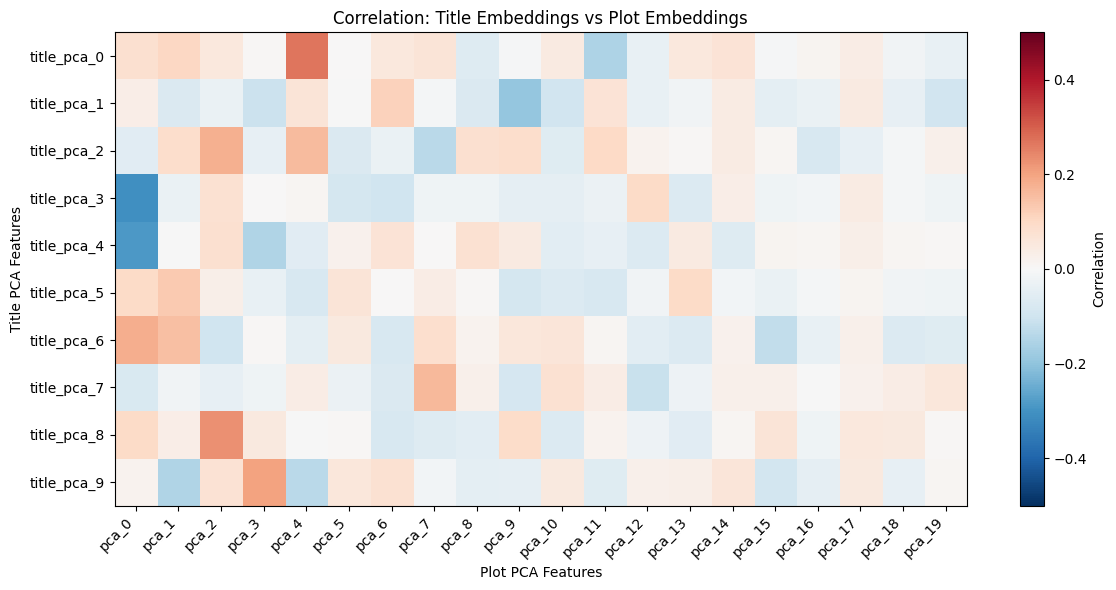


Interpretation:
- Blue = negative correlation, Red = positive correlation
- Strong colors = title and plot capture similar information
- Faint colors = title captures different information than plot


In [21]:
# Visual: Heatmap of title PCA vs plot PCA correlation
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(cross_corr.values, cmap='RdBu_r', vmin=-0.5, vmax=0.5, aspect='auto')

# Labels
ax.set_xticks(range(len(PLOT_PCA_COLS)))
ax.set_yticks(range(len(TITLE_PCA_COLS)))
ax.set_xticklabels(PLOT_PCA_COLS, rotation=45, ha='right')
ax.set_yticklabels(TITLE_PCA_COLS)

ax.set_xlabel("Plot PCA Features")
ax.set_ylabel("Title PCA Features")
ax.set_title("Correlation: Title Embeddings vs Plot Embeddings")

plt.colorbar(im, ax=ax, label="Correlation")
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Blue = negative correlation, Red = positive correlation")
print("- Strong colors = title and plot capture similar information")
print("- Faint colors = title captures different information than plot")

In [25]:
# Correlation: Plot PCA vs other features (genres, runtime, etc.)
print("=" * 60)
print("PLOT PCA vs OTHER FEATURES CORRELATION")
print("=" * 60)

other_features = ["runtimeMinutes_capped", "movie_age", "decade", "log_budget", "genre_count"] + top_genres

plot_other_corr = df[PLOT_PCA_COLS + other_features].corr()
cross_corr_other = plot_other_corr.loc[PLOT_PCA_COLS, other_features]

# Find highest correlations
print("\nHighest correlations between plot_pca and other features:")
other_pairs = []
for pca_col in PLOT_PCA_COLS:
    for other_col in other_features:
        other_pairs.append({
            "pca_feature": pca_col,
            "other_feature": other_col,
            "correlation": cross_corr_other.loc[pca_col, other_col]
        })

other_df = pd.DataFrame(other_pairs)
other_df["abs_corr"] = other_df["correlation"].abs()
other_df = other_df.sort_values("abs_corr", ascending=False)
print(other_df.head(20)[["pca_feature", "other_feature", "correlation"]].to_string(index=False))

print(f"\nMax plot-other correlation: {other_df['abs_corr'].max():.4f}")
print(f"Mean plot-other correlation: {other_df['abs_corr'].mean():.4f}")

PLOT PCA vs OTHER FEATURES CORRELATION

Highest correlations between plot_pca and other features:
pca_feature         other_feature  correlation
      pca_1     Genre_Documentary     0.363015
      pca_0          Genre_Action    -0.299156
      pca_2          Genre_Horror     0.270144
      pca_7          Genre_Horror    -0.262056
      pca_1          Genre_Action    -0.219603
      pca_0           Genre_Drama     0.214731
      pca_0     Genre_Documentary    -0.211659
      pca_4          Genre_Horror    -0.208423
      pca_4 runtimeMinutes_capped     0.186550
      pca_1           genre_count    -0.181729
     pca_11             movie_age     0.166854
     pca_11                decade    -0.165209
      pca_9           Genre_Drama    -0.154507
     pca_10           Genre_Drama     0.153091
      pca_8             movie_age     0.144798
      pca_8                decade    -0.143758
     pca_13     Genre_Documentary     0.142354
     pca_10          Genre_Horror    -0.138489
      pca

---
## 6. Decision & Export

In [22]:
# Based on results, decide which model to use
print("=" * 60)
print("FINAL DECISION")
print("=" * 60)

if result_v6["R2"] > result_v5["R2"]:
    print(f"\n✅ V6 is better (R² {result_v6['R2']:.4f} vs {result_v5['R2']:.4f})")
    print("   Proceeding with V6 as new production model...")
    FINAL_FEATURES = FEATURES_V6
    FINAL_MODEL_NAME = "v6"
else:
    print(f"\n⚠️ V5 is still better or equal (R² {result_v5['R2']:.4f} vs {result_v6['R2']:.4f})")
    print("   Keeping V5 as production model...")
    FINAL_FEATURES = FEATURES_V5
    FINAL_MODEL_NAME = "v5"

print(f"\nFinal model: {FINAL_MODEL_NAME}")
print(f"Final features: {len(FINAL_FEATURES)}")

FINAL DECISION

⚠️ V5 is still better or equal (R² 0.4099 vs 0.4072)
   Keeping V5 as production model...

Final model: v5
Final features: 49


In [23]:
# Only export if V6 is better
if FINAL_MODEL_NAME == "v6":
    import pickle
    import json
    
    # Retrain on full data
    print("Retraining V6 on full dataset...")
    X_full = df[FEATURES_V6].fillna(0)
    y_full = df[TARGET]
    
    model_v6_prod = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
    model_v6_prod.fit(X_full, y_full)
    
    # Save model
    model_path = MODELS_DIR / "model_v6.pkl"
    with open(model_path, "wb") as f:
        pickle.dump(model_v6_prod, f)
    print(f"✓ Model saved: {model_path}")
    
    # Save feature list
    features_path = MODELS_DIR / "features_v6.json"
    with open(features_path, "w") as f:
        json.dump(FEATURES_V6, f, indent=2)
    print(f"✓ Features saved: {features_path}")
    
    print(f"\n✅ V6 artifacts exported to {MODELS_DIR}/")
else:
    print("\nNo export needed - keeping existing V5 model.")


No export needed - keeping existing V5 model.


---
## 7. Summary

In [24]:
print("=" * 60)
print("EXPERIMENT SUMMARY")
print("=" * 60)
print(f"""
Question: Do title features improve movie rating prediction?

Experiment:
  - V5 (baseline): {result_v5['n_features']} features, R² = {result_v5['R2']:.4f}
  - V6 (+ title):  {result_v6['n_features']} features, R² = {result_v6['R2']:.4f}

Title features added:
  - title_has_colon (subtitle indicator)
  - title_pca_0 to title_pca_9 (semantic embeddings)

Result: R² change = {r2_diff:+.4f} ({pct_improvement:+.2f}%)

Conclusion: {'Title features HELP' if r2_diff > 0.005 else 'Title features have minimal impact' if r2_diff > -0.005 else 'Title features HURT'}
""")

EXPERIMENT SUMMARY

Question: Do title features improve movie rating prediction?

Experiment:
  - V5 (baseline): 49 features, R² = 0.4099
  - V6 (+ title):  60 features, R² = 0.4072

Title features added:
  - title_has_colon (subtitle indicator)
  - title_pca_0 to title_pca_9 (semantic embeddings)

Result: R² change = -0.0027 (-0.66%)

Conclusion: Title features have minimal impact

